# Spam detection

<img src="Images/spam_header.png">

# Introduction
## Goal

As a part of the eigth project of my Data Analyst training, my goal here is to train my skills in **text analysis** by making an **exploratory data analysis** and creating a **spam detector model**. But what are spams exactly?

## Context

According to the *Oxford dictionnary*, spams are:
>Irrelevant or unsolicited messages sent over the Internet, typically to a large number of users, for the purposes of advertising, phishing, spreading malware, etc.

The definition is broad enough to include unwanted messages in: instant messaging apps (e.g. *WhatsApp*), forums, blogs, mobile phone messaging systems, etc. Despite that fact, when I use the word *spam* in this analysis, I mean email spam: the oldest and most common form. The word *ham* will be used for legit emails.

Due to the fact that the cost of sending an email is inconsiderable, it is easy to send a message to millions of recipients. According to the *M3AAWG*, 90% of emails were junk by 2014 and that can be burden for servers (apart from their potential annoyance for users). Therefore, spam detectors are indispensable.

As you can see on [Wikipedia](https://en.wikipedia.org/wiki/Anti-spam_techniques), many Anti-spam techniques exist. Machine learning is particularly suited for this problem, because of its ability to learn from past data and predict the category of new observations. Indeed, the body of an email can vary greatly and several methods are used by spammers to be less detectable. For example, they could alter red herrings words (e.g. "s3x" instead of "sex") or use a spam image (making *Natural language processing* useless). From defendant's side: sender's address, attachments, URLs, etc. can be used also. All of that make feature extraction and feature engineering crucial: creating good features for the machine learning system to produce accurate inferences.

To study this problematic, we will use the *2007 TREC Public Spam Corpus*. This is a dataset composed of roughly 75 000 messages, collected from a server in 2007 and lightly processed. All observations are labeled: one third are junk, two thirds are ham. It is a supervised learning problem, we have already a class for each email and we want our model to be able, once trained, to predict the label (*spam* or *ham*) of an previously-unseen message.

Spam detection belongs to the security field. At first, I wanted to work on a machine learning–based malware detection tool after reading *Malware Data Science*. I would have performed a *static analysis* or examined *printable strings* from a dataset containing malwares and begninwares. However, this idea had its shortcomings compared to spam-filters: 
- Assembly language is not meaningful for the casual reader.
- Data visualization is harder.
- You can do more processing operations with emails (e.g. stemming) and so learn more concepts.
- I needed more computational power.
- Antiviruses can be cumbersome even if malwares are neutralized.

Anyway, I was inspired by the approach laid out in *Malware Data Science*: 
<img src="Images/data_science_workflow.PNG">

Sources:
- https://www.lexico.com/en/definition/spam
- https://www.m3aawg.org/for-the-industry/email-metrics-report
- https://plg.uwaterloo.ca/~gvcormac/treccorpus07/
- https://en.wikipedia.org/wiki/Anti-spam_techniques#Machine-learning-based_systems


## Objectives

The structure of this work is inspired by this schema also: 
<img src="Images/text_model_process.png">


These are the steps we have to through in order to reach our goal:
- **Collect data** from the problem we want to solve. - Already done
- **Data preprocessing**
  - Tokenization - This is the act of breaking up a sequence of strings( of our different emails that constitute our dataset) into words.
  - Normalization - Process of harmonization of all the tokens.
  - Dataframing - Put all the data into a Pandas dataframe.
- **Exploratory data analysis** - This step includes *exploratory data analysis* (aka *EDA*) to research new features and communicate visually our discoveries
  - Distribution of the target variable
  - Distribution of length of messages
  - Wordclouds
- **Extract features** - Most of Machine learning algorithms do not understand text directly, we need to represent each observation as an array of numbers.
- **Train the ML algorithm** to distinguish spams from hams. We will use a naive bayes classifier.
- **Test our system** on emails not used in the training process to see how well it performs. We will plot the ROC curve also.


## Intellectual Material

Below, I have listed all the material that helped me in this project: 
- https://www.datacamp.com/community/tutorials/text-analytics-beginners-nltk
- https://nostarch.com/malwaredatascience
- https://mlsec.net
- https://inclass.kaggle.com/dejavu23/sms-spam-or-ham-beginner
- https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/03.10-Working-With-Strings.ipynb
- https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.02-Introducing-Scikit-Learn.ipynb
- https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.03-Hyperparameters-and-Model-Validation.ipynb
- https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.04-Feature-Engineering.ipynb
- https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.05-Naive-Bayes.ipynb
- https://nbviewer.jupyter.org/github/ClickSecurity/data_hacking/blob/master/dga_detection/DGA_Domain_Detection.ipynb
- https://towardsdatascience.com/machine-learning-text-processing-1d5a2d638958
- https://medium.com/@pemagrg/pre-processing-text-in-python-ad13ea544dae
- https://github.com/jupyter/jupyter/wiki/A-gallery-of-interesting-Jupyter-Notebooks#linguistics-and-text-mining
- https://machinelearningmastery.com/prepare-news-articles-text-summarization/
- https://www.datacamp.com/community/tutorials/reading-writing-files-python
- https://www.datacamp.com/community/tutorials/stemming-lemmatization-python

# Part 0: Imports, ressources and constant variables
## Imports

In [1]:
import copy # to copy lists of dictionnaries
import email # for managing email messages
import os
import pprint # “pretty-print” for Python data structures

# Strings manipulation
import nltk
import re
import sys
import string
import unicodedata

# Data manipulation
import numpy as np
import pandas as pd

# Data Viz
import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud

## NLP ressources

In [2]:
# Download Nltk Ressources if not found
try:
    nltk.data.find(os.path.join('tokenizers', 'punkt'))
except LookupError:
    nltk.download('punkt')
    
try:
    nltk.data.find(os.path.join('corpora', 'stopwords'))
except LookupError:
    nltk.download('stopwords')

try:
    nltk.data.find(os.path.join('corpora', 'wordnet'))
except LookupError:
    nltk.download('wordnet')

## Constant variables

In [3]:
DATA_DIR = 'Dataset/data/'
LABELS_FILENAME = 'Dataset/full/index'
TESTING_SET_RATIO = 0.2

# Part 1: Pre-processing

## First glimpse at our dataset

In [4]:
# Informations about the emails
file_list = os.listdir(DATA_DIR)
print("***Number of emails***")
print(len(file_list))

print("\n***Overview of file names***")
pprint.pprint(file_list[:10])

first_file_name = os.path.join(DATA_DIR, file_list[0])
print("\n***Display of the first file***")
print(open(first_file_name).read())

***Number of emails***
75419

***Overview of file names***
['inmail.1',
 'inmail.10',
 'inmail.100',
 'inmail.1000',
 'inmail.10000',
 'inmail.10001',
 'inmail.10002',
 'inmail.10003',
 'inmail.10004',
 'inmail.10005']

***Display of the first file***
From RickyAmes@aol.com  Sun Apr  8 13:07:32 2007
Return-Path: <RickyAmes@aol.com>
Received: from 129.97.78.23 ([211.202.101.74])
	by speedy.uwaterloo.ca (8.12.8/8.12.5) with SMTP id l38H7G0I003017;
	Sun, 8 Apr 2007 13:07:21 -0400
Received: from 0.144.152.6 by 211.202.101.74; Sun, 08 Apr 2007 19:04:48 +0100
Message-ID: <WYADCKPDFWWTWTXNFVUE@yahoo.com>
From: "Tomas Jacobs" <RickyAmes@aol.com>
Reply-To: "Tomas Jacobs" <RickyAmes@aol.com>
To: the00@speedy.uwaterloo.ca
Subject: Generic Cialis, branded quality@ 
Date: Sun, 08 Apr 2007 21:00:48 +0300
X-Mailer: Microsoft Outlook Express 6.00.2600.0000
MIME-Version: 1.0
Content-Type: multipart/alternative;
	boundary="--8896484051606557286"
X-Priority: 3
X-MSMail-Priority: Normal
Status: RO
Content

In [5]:
# What the labels look like 
print(open(LABELS_FILENAME).read()[:109])

spam ../data/inmail.1
ham ../data/inmail.2
spam ../data/inmail.3
spam ../data/inmail.4
spam ../data/inmail.5



## Loading

We use the Python library named *email* to load our dataset. It enables us to manage the *MIME* content of our observations. According to [WhatIs.com](https://whatis.techtarget.com/definition/MIME-Multi-Purpose-Internet-Mail-Extensions), *MIME* (*Multipurpose Internet Mail Extensions*):
>is an extension of the original Internet e-mail protocol that lets people use the protocol to exchange different kinds of data files on the Internet: audio, video, images, application programs, and other kinds, as well as the ASCII text handled in the original protocol, the Simple Mail Transport Protocol (SMTP).

With the libary and the protocol we can perfom the following loading operations: 
- Extract the subject and the body separately.
- Extract all the parts of an email is this one is made of multiple parts.
- Do not load attachements - They cannot be used by our text approach.
- Store the body and subject as strings to clean them later.

The loaded dataset will be stored as a list of dictionnaries. This method allows to transform easily our data into a dataframe later. Each e-mail will be stored with four attributes:
- **email_id** - Name of the file (e.g. "inmail.9")
- **subject**
- **body** 
- **is_spam** - The label *spam* or *ham*, represented in a binary way for *Scikit-learn*.

In [6]:
# ALL LOADING FUNCTIONS
# Combine the different parts of the email into a flat list of strings
def flatten_to_string(parts):
    ret = []
    if type(parts) == str:
        ret.append(parts)
    elif type(parts) == list:
        for part in parts:
            if any(x in part.get_content_type() for x in ["multipart" ,"text"]): 
                ret += flatten_to_string(part.get_payload())
    else:
        ret.append(parts.get_payload())
    return ret

# Extract subject and body text from a single email file
def split_email(path):
    # Load a single email from an input file
    with open(path, errors='ignore') as f:
        msg = email.message_from_file(f)
    if not msg:
        return ""

    # Read the email subject
    subject = msg['Subject']
    if not subject:
        subject = ""
    
    # Read the email body
    body = ' '.join(m for m in flatten_to_string(msg.get_payload())
                    if type(m) == str)
    if not body:
        body = ""
        
    return subject, body

def load_email_files(emails_directory, label_filename):
    emails_data = list()
    
    with open(label_filename) as labels_file:
        for line in labels_file:
            # Extract label and filename
            line = line.strip()
            label, filename = line.split()
            label = 1 if label.lower() == 'spam' else 0
            filename = filename.split('/')[-1]

            # Extract subject and body
            subject, body = split_email(os.path.join(emails_directory, filename))

            # store
            emails_data.append({'email_id': filename, 'subject':subject, 'body':body, 'is_spam': label})
    return emails_data

In [7]:
raw_emails = load_email_files(DATA_DIR, LABELS_FILENAME)

In [8]:
pprint.pprint(raw_emails[3:5])

[{'body': '\n'
          'Hey Billy, \n'
          '\n'
          'it was really fun going out the other night \n'
          'and talking, while we were out you said that you felt\n'
          'insecure about your manhood, I noticed in the toilets\n'
          'you were quite small in that area : ) , but not to \n'
          'worry.. that website that I was telling you about is \n'
          'my secret weapon to an extra 3 inches, trust me.. girls\n'
          "love bigger ones, I've had 5 times as many chicks \n"
          'since I used these pills a year ago. The package I used\n'
          'was the 6 month supply one,  and its worth every \n'
          'cent and more.. the website is http://ctmay.com \n'
          'Ring me on the weekend and we will go out and drink \n'
          'again and let you know some more secrets : ).\n'
          'Later dude, Brad\n'
          '\n',
  'email_id': 'inmail.4',
  'is_spam': 1,
  'subject': 'Nice talking with ya'},
 {'body': '\n'
          'sys

As you can see with the "inmail.5", when there are too many characters on the same line, they are reported on the next line and a "=" is added. Therefore, some words are cut. We need to correct that in order to avoid problems with EDA and the classifier.

## Cleaning

All cleaning operations we undertake are as follows:
- Flattening the strings - Characters separated by "=\n" will be merged and "\n" (new line character) will be replaced by a space.
- Removing html tags - We want only study the content of our emails. 
- Removing urls and emails - Each one of them will make a new column in our bag of words approach if we keep them.
- Removing non-ascii-string - Erase all strange strings like the one used to store gifs or images. The drawback of this operation is that it deletes all non-english words like "élan" or "französisch".
- Removing stopwords - Stopwords are very common words in English (e.g. "the") that do not provide informative value for understanding the meaning of a message.
- Tokenizing on white space and punctuation. - This action removes punctuation.
- Converting to lowercase. - It reduces the number of different strings while keeping their meanings.
- Removing tokens with numbers in them.
- Removing tokens smaller than two characters.
- Lemmatization - Process of representing words in their canonical form. For example, for a noun, it will be its singular form. It will improve the results of our classifier.

In [9]:
# ALL CLEANING FUNCTIONS
# Clean a string
def clean_string(text, regex, stop_words, lemmatizer):
    cleaned = ''
    # To avoid problems with end of lines
    text = re.sub('=\n', '', text)
    text = re.sub('\n', ' ', text)
    # Remove words containing the regular expression
    text = re.sub(regex, ' ', text) # Replaced with space to avoid problems with tags
    # tokenize on white space and punctuation
    tokens =  nltk.tokenize.RegexpTokenizer(r'\w+').tokenize(text)
    for token in tokens:
        # convert to lower case
        token = token.lower()
        # remove tokens with numbers in them
        if token.isalpha():
            pass
        else: 
            continue
        # remove stop words
        if token not in stop_words:
            pass
        else: 
            continue
        # Remove useless strings
        if len(token) > 2: 
            pass
        else: 
            continue
        # lemmatize words
        token = lemmatizer.lemmatize(token)
        # store as string
        cleaned = ' '.join((cleaned, token))
    # remove useless spaces 
    cleaned = re.sub(' +', ' ', cleaned)
    # remove leading and trailig whitespaces
    cleaned = cleaned.strip()
    return cleaned

# Clean a dict of emails
def clean_emails(emails):
    # Regular expression 
    regex = re.compile(r'''(
        <style.*?>.*?<\/style> #css
        |<.*?>|&([a-z0-9]+|\#[0-9]{1,6}|\#x[0-9a-f]{1,6}); # html tags
        |((http|ftp|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])* # Urls
        |^[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+$ # emails
        |[^\x00-\x7f] # non-ascii-string
        )''', re.VERBOSE | re.IGNORECASE | re.MULTILINE)
    stop_words = set(nltk.corpus.stopwords.words('english'))
    lemmatizer = nltk.stem.WordNetLemmatizer() 

    for email in emails:
        email['subject'] = clean_string(email['subject'], regex, stop_words, lemmatizer)
        email['body'] = clean_string(email['body'], regex, stop_words, lemmatizer)
    return emails

In [10]:
# The link below explain why I use deep copy
# https://medium.com/@thawsitt/assignment-vs-shallow-copy-vs-deep-copy-in-python-f70c2f0ebd86
emails = copy.deepcopy(raw_emails)
emails = clean_emails(emails)

In [11]:
pprint.pprint(emails[:5])

[{'body': 'feel pressure perform rising occasion try anxiety thing past back '
          'old self',
  'email_id': 'inmail.1',
  'is_spam': 1,
  'subject': 'generic cialis branded quality'},
 {'body': 'updated gulu check mirror seems little typo debian readme file '
          'example testing lenny access release dists testing current tested '
          'development snapshot named etch package tested unstable passed '
          'automated test propogate release etch replace lenny like yan morin '
          'consultant logiciel libre unsubscribe email subject unsubscribe '
          'trouble contact',
  'email_id': 'inmail.2',
  'is_spam': 0,
  'subject': 'typo debian readme'},
 {'body': 'mega authenticv discount pricec discount pricedo miss click '
          'authentic viagra mega authentic discount price discount price miss '
          'click',
  'email_id': 'inmail.3',
  'is_spam': 1,
  'subject': 'authentic viagra'},
 {'body': 'hey billy really fun going night talking said felt inse

As you can see, emails are tokenized properly. Each body and subject is stored as a flat string. Inside it, each token is separated by a space. 

## Dataframing

In [12]:
# https://pbpython.com/pandas-list-dict.html
df = pd.DataFrame(emails)

# Show results
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75419 entries, 0 to 75418
Data columns (total 4 columns):
email_id    75419 non-null object
subject     75419 non-null object
body        75419 non-null object
is_spam     75419 non-null int64
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


,email_id,subject,body,is_spam
0,inmail.1,generic cialis branded quality,feel pressure perform rising occasion try anxi...,1
1,inmail.2,typo debian readme,updated gulu check mirror seems little typo de...,0
2,inmail.3,authentic viagra,mega authenticv discount pricec discount price...,1
3,inmail.4,nice talking,hey billy really fun going night talking said ...,1
4,inmail.5,trembling stomach cramp trouble sleeping weakn...,system home capability linked far know within ...,1


In [13]:
# Add label for easier plots
df['label'] = ['spam' if x ==1 else 'ham' for x in df['is_spam']] 

# Show results
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75419 entries, 0 to 75418
Data columns (total 5 columns):
email_id    75419 non-null object
subject     75419 non-null object
body        75419 non-null object
is_spam     75419 non-null int64
label       75419 non-null object
dtypes: int64(1), object(4)
memory usage: 2.9+ MB


,email_id,subject,body,is_spam,label
0,inmail.1,generic cialis branded quality,feel pressure perform rising occasion try anxi...,1,spam
1,inmail.2,typo debian readme,updated gulu check mirror seems little typo de...,0,ham
2,inmail.3,authentic viagra,mega authenticv discount pricec discount price...,1,spam
3,inmail.4,nice talking,hey billy really fun going night talking said ...,1,spam
4,inmail.5,trembling stomach cramp trouble sleeping weakn...,system home capability linked far know within ...,1,spam


In [14]:
# Change the columns to the correct kinds of dtypes
df = df.astype({'label': 'category'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75419 entries, 0 to 75418
Data columns (total 5 columns):
email_id    75419 non-null object
subject     75419 non-null object
body        75419 non-null object
is_spam     75419 non-null int64
label       75419 non-null category
dtypes: category(1), int64(1), object(3)
memory usage: 2.4+ MB


# Part 2: EDA

In [15]:
df.loc[:, df.columns != 'is_spam'].describe()

,email_id,subject,body,label
count,75419,75419,75419,75419
unique,75419,23422,51948,2
top,inmail.58014,,,spam
freq,1,4657,3591,50199


Not all email subjects and email bodies are unique.

## Dealing with missing values

In [16]:
print(df[df.subject == ''].shape[0]) # Nb of empty subjects
df[df.subject == ''].head()

4657


,email_id,subject,body,is_spam,label
47,inmail.48,,experience charging bull next soda giant fire ...,1,spam
51,inmail.52,,,1,spam
60,inmail.61,,seen sub one cent company take good news past ...,1,spam
78,inmail.79,,seen sub one cent company take good news past ...,1,spam
79,inmail.80,,,1,spam


In [17]:
print(df[df.body == ''].shape[0])
df[df.body == ''].head()

3591


,email_id,subject,body,is_spam,label
14,inmail.15,cure desease,,1,spam
21,inmail.22,cure desease,,1,spam
22,inmail.23,need medicine,,1,spam
23,inmail.24,need medicine,,1,spam
29,inmail.30,product health,,1,spam


In [18]:
df[(df.body == '') & (df.subject == '')].shape[0]

409

Because of the cleaning process, some emails have no body nor subject. In order not to loose too many observations, (4657 + 3591), it is better to consider each subject and body altogether by concatenating them. Indeed, this way only a few messages are really empty. These ones will be deleted for the rest of our analysis.

In [19]:
df = df[~((df.body == '') & (df.subject == ''))]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75010 entries, 0 to 75418
Data columns (total 5 columns):
email_id    75010 non-null object
subject     75010 non-null object
body        75010 non-null object
is_spam     75010 non-null int64
label       75010 non-null category
dtypes: category(1), int64(1), object(3)
memory usage: 2.9+ MB


In [20]:
# Concatenation of subject and body
df['text'] = df['subject'] + ' ' + df['body']

Now it is interesting to see if we have still duplicates when we consider texts as a whole.

In [21]:
duplicated_texts = df.duplicated(['text'])
df.loc[duplicated_texts, df.columns != 'is_spam'].describe()

,email_id,subject,body,label,text
count,18264,18264,18264,18264,18264
unique,18264,2039,2009,2,3116
top,inmail.67706,avis important personnel,,spam,avis important personnel mouvement desjardins ...
freq,1,2970,2720,16911,2617


In [22]:
df.loc[duplicated_texts, ['text', 'label']].groupby('label').describe()

text                                                                
       count unique                                                top  freq
label                                                                       
ham     1353    580  stock notification satcon technology corporati...    61
spam   16911   2546  avis important personnel mouvement desjardins ...  2617

In [23]:
df[df['text'].str.contains('desjardins')].shape[0]

3266

That is not suprising to notice that more spams are not unique because they are sent to many addresses. In our case, this may bias our analysis due to the fact that our sample is relatively small.

## Distribution of hams and spams

In [24]:
df.label.value_counts()

spam    49792
ham     25218
Name: label, dtype: int64

Our dataset contains 49792 spams and 25218 spam messages.

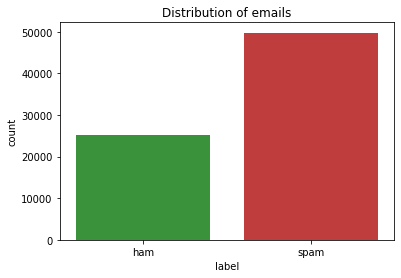

In [25]:
ax = sns.countplot(x="label", data=df, palette=["C2", "C3"])
plt.title("Distribution of emails")
plt.show()

## Number of words per message

In [26]:
# Get the number of words for each email
df['nb_words'] = df['text'].apply(lambda x: len(str(x).split(' ')))
df.head()

,email_id,subject,body,is_spam,label,text,nb_words
0,inmail.1,generic cialis branded quality,feel pressure perform rising occasion try anxi...,1,spam,generic cialis branded quality feel pressure p...,16
1,inmail.2,typo debian readme,updated gulu check mirror seems little typo de...,0,ham,typo debian readme updated gulu check mirror s...,49
2,inmail.3,authentic viagra,mega authenticv discount pricec discount price...,1,spam,authentic viagra mega authenticv discount pric...,20
3,inmail.4,nice talking,hey billy really fun going night talking said ...,1,spam,nice talking hey billy really fun going night ...,56
4,inmail.5,trembling stomach cramp trouble sleeping weakn...,system home capability linked far know within ...,1,spam,trembling stomach cramp trouble sleeping weakn...,411


In [27]:
df['nb_words'].describe()

count    75010.000000
mean       144.906719
std        287.629849
min          2.000000
25%         43.000000
50%         87.000000
75%        175.000000
max      36005.000000
Name: nb_words, dtype: float64

In [28]:
df.loc[:,['nb_words', 'label']].groupby('label').describe()

nb_words                                                         
         count        mean         std  min   25%   50%    75%      max
label                                                                  
ham    25218.0  191.237093  406.586982  2.0  59.0  99.0  180.0  36005.0
spam   49792.0  121.441918  198.168049  2.0  33.0  79.0  170.0  10303.0

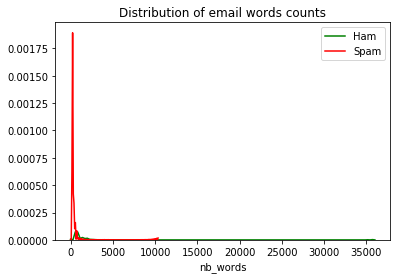

In [29]:
sns.distplot(df.loc[df['label'] == 'ham', 'nb_words'], hist = False, kde = True, label='Ham', color="green")
sns.distplot(df.loc[df['label'] == 'spam', 'nb_words'], hist = False, kde = True, label='Spam', color="red")
plt.title("Distribution of email words counts")
plt.legend()
plt.show()

Outliers make our plot hard to read.

In [30]:
# Show outliers
df.nlargest(15, 'nb_words')

,email_id,subject,body,is_spam,label,text,nb_words
51800,inmail.51801,patch commit generated prototype header,commit snapshot generated prototype header sou...,0,ham,patch commit generated prototype header commit...,36005
13628,inmail.13629,investment read please,dear friend make appeal understanding fact opi...,1,spam,investment read please dear friend make appeal...,10303
13624,inmail.13625,investment read please,dear friend make appeal understanding fact opi...,1,spam,investment read please dear friend make appeal...,10101
13625,inmail.13626,investment read please,dear friend make appeal understanding fact opi...,1,spam,investment read please dear friend make appeal...,10101
13626,inmail.13627,investment read please,dear friend make appeal understanding fact opi...,1,spam,investment read please dear friend make appeal...,10101
64813,inmail.64814,pls reply,sgt kofi michelle via email dear sir hope emai...,1,spam,pls reply sgt kofi michelle via email dear sir...,7458
70180,inmail.70181,msn list digest vol issue,send msn list mailing list submission subscrib...,0,ham,msn list digest vol issue send msn list mailin...,7065
2414,inmail.2415,sugar error starting sugar,tuesday april bert freudenberg wrote interesti...,0,ham,sugar error starting sugar tuesday april bert ...,6603
66453,inmail.66454,matlab gauss code,mean import access matlab yes considered using...,0,ham,matlab gauss code mean import access matlab ye...,6601
65387,inmail.65388,matlab gauss code,would like import matlab gauss code could help...,0,ham,matlab gauss code would like import matlab gau...,6554


We have to take into account these outliers if we do not want to get bad plots.

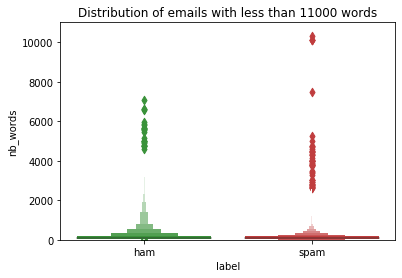

In [31]:
sns.boxenplot(x=df.label, y=df.nb_words, palette=["C2", "C3"])
plt.title('Distribution of emails with less than 11000 words')
plt.ylim(0, 11000)
plt.show()

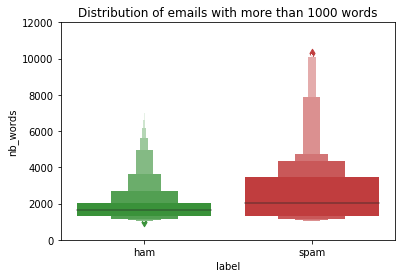

In [32]:
sns.boxenplot(x=df.loc[df.nb_words > 1000].label, y=df.loc[df.nb_words > 1000].nb_words, palette=["C2", "C3"])
plt.title('Distribution of emails with more than 1000 words')
plt.ylim(0, 12000)
plt.show()

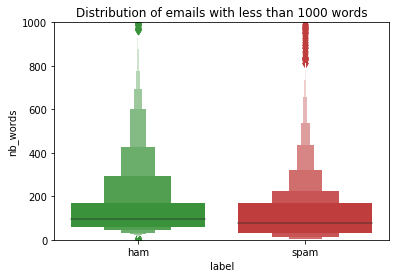

In [33]:
sns.boxenplot(x=df.loc[df.nb_words < 1000].label, y=df.loc[df.nb_words < 1000].nb_words, palette=["C2", "C3"])
plt.ylim(0, 1000)
plt.title('Distribution of emails with less than 1000 words')
plt.show()

It seems irrelevant to use the number of words of each message as a feature for our problem.

## Wordclouds

A Wordcloud is a visual representation of all or some of the keywords in a corpus. The bigger the word, the more it appears. It highlights the vocabulary used and help us to detect problems with the cleaning process.

For example, I detected a problem with [HTML Entities](https://www.w3schools.com/html/html_entities.asp). Indeed, "nbsp" was one of the top words:
>A common character entity used in HTML is the non-breaking space: <strong>&nbsp ;</strong>
>
>A non-breaking space is a space that will not break into a new line.

To deal with it, I improved my regular expression used to clean the dataset.

In [34]:
# https://www.datacamp.com/community/tutorials/wordcloud-python
def plot_wordcloud(df, title, colormap):
    text = ' '.join(df['text'].astype(str).tolist())
    
    fig_wordcloud = wordcloud.WordCloud(background_color='white',
                    colormap=colormap, width=800, height=600).generate(text)
    
    plt.figure(figsize=(10,7), frameon=True)
    plt.imshow(fig_wordcloud, interpolation='bilinear')  
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.show()

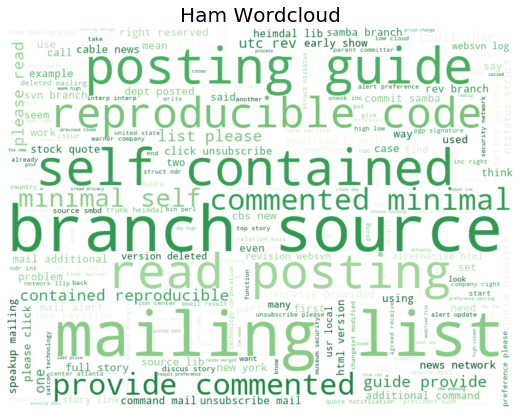

In [35]:
plot_wordcloud(df[df['label'] == 'ham'], "Ham Wordcloud", "Greens_r")

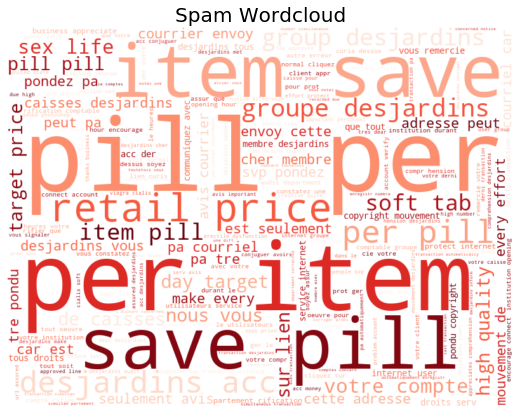

In [36]:
plot_wordcloud(df[df['label'] == 'spam'], "Spam Wordcloud", "Reds")

## Top words in hams and spam

In [37]:
# List all the words in the dataset for each label
ham_words = []
for sublist in df.loc[df['label'] == 'ham', 'text'].apply(lambda x: str(x).split(' ')).tolist():
    for item in sublist:
        ham_words.append(item)

spam_words = []
for sublist in df.loc[df['label'] == 'spam', 'text'].apply(lambda x: str(x).split(' ')).tolist():
    for item in sublist:
        spam_words.append(item)       

In [38]:
# Compute the frequence of appearance of each word
fdist_ham  = nltk.FreqDist(ham_words)
fdist_spam = nltk.FreqDist(spam_words)

print("Unique ham words: {}".format(len(fdist_ham)))
print("Unique spam words: {}".format(len(fdist_spam)))

Unique ham words: 85615
Unique spam words: 113428


In [39]:
df_hamwords_top20  = pd.DataFrame(fdist_ham.most_common(20),  columns=['word', 'count'])
df_spamwords_top20 = pd.DataFrame(fdist_spam.most_common(20), columns=['word', 'count'])

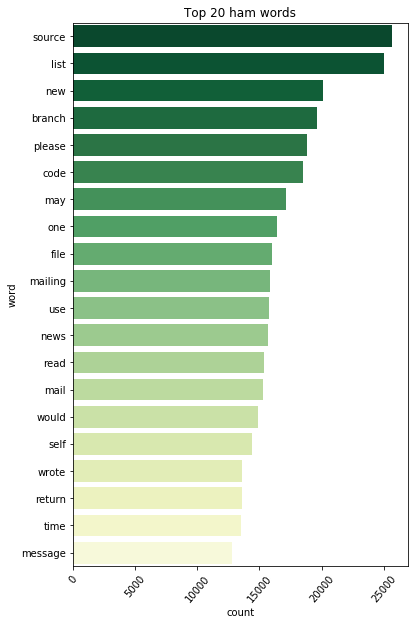

In [40]:
fig, ax = plt.subplots(figsize=(6, 10))
sns.barplot(x='count', y='word', data=df_hamwords_top20,
            palette="YlGn_r", ax=ax)
plt.xticks(rotation=50)
plt.title("Top 20 ham words")
plt.show()

Some top ham words makes us think that there are some emails about programming, the rest is more classic.

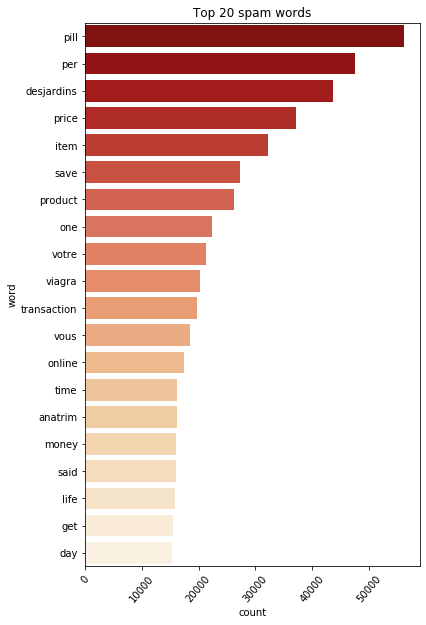

In [41]:
fig, ax = plt.subplots(figsize=(6, 10))
sns.barplot(x='count', y='word', data=df_spamwords_top20,
            palette="OrRd_r", ax=ax)
plt.xticks(rotation=50)
plt.title("Top 20 spam words")
plt.show()

As expected, spams are about: money, pills, products, etc. We can notice that there are some French words (desjardins, votre, vous).

# Part 3: Features extraction

As stated in *Machine Learning with Python Cookbook*, Bag-of-words are:
>Bag-of-words models output a feature for every unique word in text data, with each feature containing a count of occurrences in observations.

<img src="Images/bag_of_words.png" width="350">

In this study, we want a bag of words, but with words weighted by their importance. In order to achieve this we will use the Tf-Idf method. *Applied Text Analysis with Python* explains its usefulness: 
>The bag-of-words representations only describe a document in a standalone fashion, not taking into account the context of the corpus. A better approach would be to consider the relative frequency or rareness of tokens in the document against their frequency in other documents. The central insight is that meaning is most likely encoded in the more rare terms from a document. For example, in a corpus of sports text, tokens such as “umpire,” “base,” and “dugout” appear more frequently in documents that discuss baseball, while other tokens that appear frequently throughout the corpus, like “run,” “score,” and “play,” are less important. 

>TF–IDF, *term frequency–inverse document frequency*, encoding normalizes the frequency of tokens in a document with respect to the rest of the corpus. This encoding approach accentuates terms that are very relevant to a specific instance

<img src="Images/td-idf-graphic.png" width=800/>

In [42]:
# Load libraries 
from sklearn.feature_extraction.text import TfidfVectorizer

# Change corpus in df to a numpy array 
text_data = df['text'].values

# Create the tf-idf feature matrix 
tfidf = TfidfVectorizer() 
feature_matrix = tfidf.fit_transform(text_data)

# Check if operations succeded
feature_matrix

<75010x164581 sparse matrix of type '<class 'numpy.float64'>'
	with 5910801 stored elements in Compressed Sparse Row format>

Our algorithm has to deal with 164581 different words and 75010 emails.

In [43]:
print("Percantage of non-zero entries:")
print( feature_matrix.nnz / (feature_matrix.shape[0] * feature_matrix.shape[1]) * 100 )

Percantage of non-zero entries:
0.0478792651097182


# Part 4: Training

As a starting approach to classify emails, we will try the **multinomial naive Bayes classifier**. *Python Data Science Handbook* epxlains the advantages of this alogrithm:
>- They are extremely fast for both training and prediction
>- They provide straightforward probabilistic prediction
>- They are often very easily interpretable
>- They have very few (if any) tunable parameters
>
>These advantages mean a naive Bayesian classifier is often a good choice as an initial baseline classification. If it performs suitably, then congratulations: you have a very fast, very interpretable classifier for your problem. If it does not perform well, then you can begin exploring more sophisticated models, with some baseline knowledge of how well they should perform.

In [44]:
from sklearn.model_selection import train_test_split

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(feature_matrix,
                                                    df['is_spam'].values,
                                                    test_size=TESTING_SET_RATIO,
                                                    random_state=42)
X_train

<60008x164581 sparse matrix of type '<class 'numpy.float64'>'
	with 4737305 stored elements in Compressed Sparse Row format>

In [45]:
from sklearn.naive_bayes import MultinomialNB

spam_model = MultinomialNB().fit(X_train, y_train)

# Part 5: Testing

 The accuracy score is the fraction of correctly classified examples. With more than 97% of emails correctly classified, our model seems good.
 ***
 
 To display the results of the MNB classifier, the ROC curve is well-suited:
> The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings. The true-positive rate is also known as sensitivity, recall or probability of detection in machine learning. The false-positive rate is also known as the fall-out or probability of false alarm and can be calculated as (1 − specificity).

<img src="Images/roc_curve_explanation.png" width=400>

In [46]:
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score

pred_test = spam_model.predict(X_test)
accuracy_score(y_test, pred_test)

0.9744700706572457

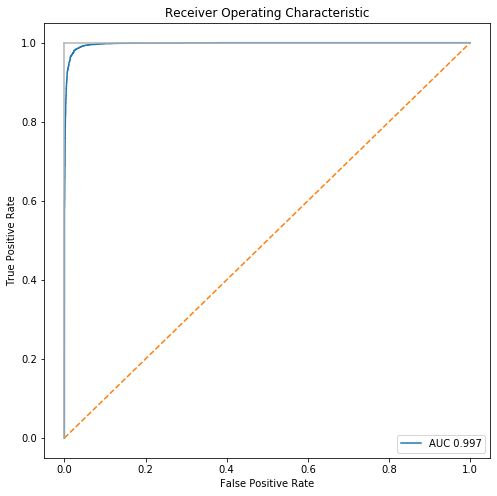

In [47]:
# Get predicted probabilities 
y_probabilities = spam_model.predict_proba(X_test)[:,1]

# Get true and false positive rates 
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_probabilities)

# Plot ROC curve 
plt.figure(figsize=(8, 8))
plt.title("Receiver Operating Characteristic")
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7") 
plt.ylabel("True Positive Rate") 
plt.xlabel("False Positive Rate") 
plt.legend(["AUC {0:.3f}".format(roc_auc_score(y_test, y_probabilities))])
plt.show()

The Area under curve and the curve shape indicate us that our classifier is very good.

<img src="Images/roc_curves_analysis.jpg" width=900>

Our classifier may be too good and we are facing a problem of overfitting. To go further in building a spam-detector, it may be wise to use cross-validation. However, it is beyond the scope of this project.

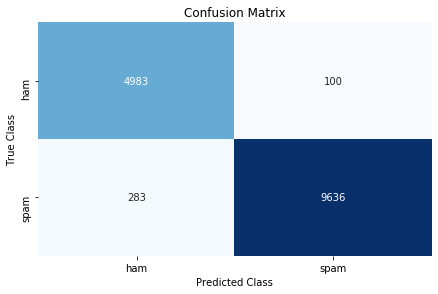

In [48]:
from sklearn.metrics import confusion_matrix

# Create confusion matrix 
matrix = confusion_matrix(y_test, pred_test)

# Create pandas dataframe 
df_mat = pd.DataFrame(matrix, index=["ham", "spam"], columns=["ham", "spam"])

# Create heatmap 
sns.heatmap(df_mat, annot=True, fmt='d', cbar=None, cmap="Blues") 
plt.title("Confusion Matrix"), 
plt.tight_layout() 
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.show()

Our algorithm misclassified only 383 emails.

# Conclusion

So far, we have succeeded in making an **exploratory data analysis** and creating a **spam detector model**. During this project I have learned many things about **text analysis**: the concepts and how to apply them.

However, this work is not exhaustive and there are many areas for improvement:
- Getting more emails from diverse sources. For example, our model might consider every french email as a spam.
- Using other kinds of algorithms and applying a cross-validation with our TF-IDF.
- Testing *Deep Learning methods* like word embeddings methods which try to representate words in a space with a form of similarity between them. This [article](https://machinelearningmastery.com/best-practices-document-classification-deep-learning/) outlines what can be donne in text classification.
- Using other kinds of features to predict the category of an email such as: the sender's IP, the sender's address, etc.
- Detecting malicious URLs (even in hams).
- Detecting malicious email attachments (even in hams).